In [0]:
dbutils.fs.mkdirs("dbfs:/FileStore/retail/")


True

In [0]:
%sh
wget https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx -O /tmp/OnlineRetail.xlsx


--2025-08-25 15:48:11--  https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘/tmp/OnlineRetail.xlsx’

     0K .......... .......... .......... .......... ..........  314K
    50K .......... .......... .......... .......... ..........  629K
   100K .......... .......... .......... .......... .......... 38.1M
   150K .......... .......... .......... .......... .......... 1.26M
   200K .......... .......... .......... .......... .......... 1.20M
   250K .......... .......... .......... .......... .......... 34.8M
   300K .......... .......... .......... .......... .......... 37.4M
   350K .......... .......... .......... .......... .......... 52.2M
   400K .......... .......... .......... .......... ..........  665K
   45

In [0]:
%sh
ls -lh /tmp/OnlineRetail.xlsx

-rw-r--r-- 1 spark-99699224-4f3c-4d9f-bcc8-11 spark-99699224-4f3c-4d9f-bcc8-11 23M Aug 25 15:48 /tmp/OnlineRetail.xlsx


In [0]:
import requests

url = (
  "https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx"
)
dbutils.fs.mkdirs("dbfs:/FileStore/retail")

response = requests.get(url)
dbutils.fs.put(
    "dbfs:/FileStore/retail/OnlineRetail.xlsx",
    '/tmp/OnlineRetail.xlsx',
    overwrite=True
)

Wrote 22 bytes.


True

In [0]:
import requests
import base64

url = (
    "https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx"
)
dbutils.fs.mkdirs("dbfs:/FileStore/retail")

response = requests.get(url)
encoded = base64.b64encode(response.content).decode("utf-8")
dbutils.fs.put(
    "dbfs:/FileStore/retail/OnlineRetail.xlsx",
    encoded,
    overwrite=True
)

Wrote 31620460 bytes.


True

In [0]:
display(dbutils.fs.ls("dbfs:/FileStore/retail/"))


path,name,size,modificationTime
dbfs:/FileStore/retail/OnlineRetail.xlsx,OnlineRetail.xlsx,31620460,1756137779000


In [0]:
%pip install openpyxl

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
import pandas as pd

# DBFS path
dbfs_path = "dbfs:/FileStore/retail/OnlineRetail.xlsx"
local_path = "/tmp/OnlineRetail.xlsx"

# Copy file from DBFS to local temp directory
dbutils.fs.cp(
    dbfs_path,
    '/dbfs/tmp/OnlineRetail.xlsx'
)

# Read the Excel file
retail_df = pd.read_excel(
    local_path,
    sheet_name=None
)

# Quick check
list(retail_df.keys())

['Online Retail']

In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum as spark_sum, month, year
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

In [0]:
# Install the spark-excel library
%pip install --upgrade pyspark

# Read Excel directly in Spark
spark_df = spark.read.format("com.crealytics.spark.excel") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .load("dbfs:/FileStore/retail/OnlineRetail.xlsx")


Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
# Copy file from DBFS to local file system
local_path = "/tmp/OnlineRetail.xlsx"
dbutils.fs.cp(
    "dbfs:/FileStore/retail/OnlineRetail.xlsx",
    local_path
)

# Read Excel using Pandas
pdf = pd.read_excel(
    local_path,
    sheet_name=None,
    engine="openpyxl"
)

# Ensure InvoiceNo, StockCode, and Description are string type
pdf["Online Retail"]["InvoiceNo"] = pdf["Online Retail"]["InvoiceNo"].astype(str)
pdf["Online Retail"]["StockCode"] = pdf["Online Retail"]["StockCode"].astype(str)
pdf["Online Retail"]["Description"] = pdf["Online Retail"]["Description"].astype(str)

# Convert Pandas DF to Spark DF
retail_df = spark.createDataFrame(
    pdf["Online Retail"]
)

# Register as temporary view for SQL queries
retail_df.createOrReplaceTempView("retail_table")

# Quick Spark overview
retail_df.printSchema()
display(
    retail_df.limit(5)
)

root
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: long (nullable = true)
 |-- InvoiceDate: timestamp (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- CustomerID: double (nullable = true)
 |-- Country: string (nullable = true)



InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01T08:26:00.000Z,2.55,17850.0,United Kingdom
536365,71053,WHITE METAL LANTERN,6,2010-12-01T08:26:00.000Z,3.39,17850.0,United Kingdom
536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01T08:26:00.000Z,2.75,17850.0,United Kingdom
536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01T08:26:00.000Z,3.39,17850.0,United Kingdom
536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01T08:26:00.000Z,3.39,17850.0,United Kingdom


In [0]:
from pyspark.sql.functions import col, to_timestamp

retail_df = retail_df.filter(col("CustomerID").isNotNull())  # Remove rows without CustomerID
retail_df = retail_df.withColumn("InvoiceDate", to_timestamp(col("InvoiceDate")))
retail_df = retail_df.withColumn("TotalPrice", col("Quantity") * col("UnitPrice"))
retail_df.createOrReplaceTempView("retail_table")


In [0]:
%sql
-- Top 10 Products by Revenue

SELECT Description, SUM(TotalPrice) AS Revenue
FROM retail_table
GROUP BY Description
ORDER BY Revenue DESC
LIMIT 10;


Description,Revenue
REGENCY CAKESTAND 3 TIER,132870.40000000005
WHITE HANGING HEART T-LIGHT HOLDER,93823.85000000005
JUMBO BAG RED RETROSPOT,83236.7599999999
PARTY BUNTING,67687.52999999994
POSTAGE,66710.24
ASSORTED COLOUR BIRD ORNAMENT,56499.22000000013
RABBIT NIGHT LIGHT,51137.79999999987
CHILLI LIGHTS,45936.810000000005
PAPER CHAIN KIT 50'S CHRISTMAS,41500.47999999998
PICNIC BASKET WICKER 60 PIECES,39619.5


In [0]:

# 4️⃣ Key Metrics (KPIs) with Spark SQL

# Total revenue
total_revenue = spark.sql("SELECT SUM(TotalPrice) AS TotalRevenue FROM retail_table")
display(total_revenue)

# Total number of orders
total_orders = spark.sql("SELECT COUNT(DISTINCT InvoiceNo) AS TotalOrders FROM retail_table")
display(total_orders)

# Total number of customers
total_customers = spark.sql("SELECT COUNT(DISTINCT CustomerID) AS TotalCustomers FROM retail_table")
display(total_customers)


TotalRevenue
8300065.8139999155


TotalOrders
22190


TotalCustomers
4372


In [0]:
#  Top 10 Products by Revenue
top_products = spark.sql("""
    SELECT Description, SUM(TotalPrice) AS Revenue
    FROM retail_table
    GROUP BY Description
    ORDER BY Revenue DESC
    LIMIT 10
""")
display(top_products)

Description,Revenue
REGENCY CAKESTAND 3 TIER,132870.40000000005
WHITE HANGING HEART T-LIGHT HOLDER,93823.85000000005
JUMBO BAG RED RETROSPOT,83236.7599999999
PARTY BUNTING,67687.52999999994
POSTAGE,66710.24
ASSORTED COLOUR BIRD ORNAMENT,56499.22000000013
RABBIT NIGHT LIGHT,51137.79999999987
CHILLI LIGHTS,45936.810000000005
PAPER CHAIN KIT 50'S CHRISTMAS,41500.47999999998
PICNIC BASKET WICKER 60 PIECES,39619.5


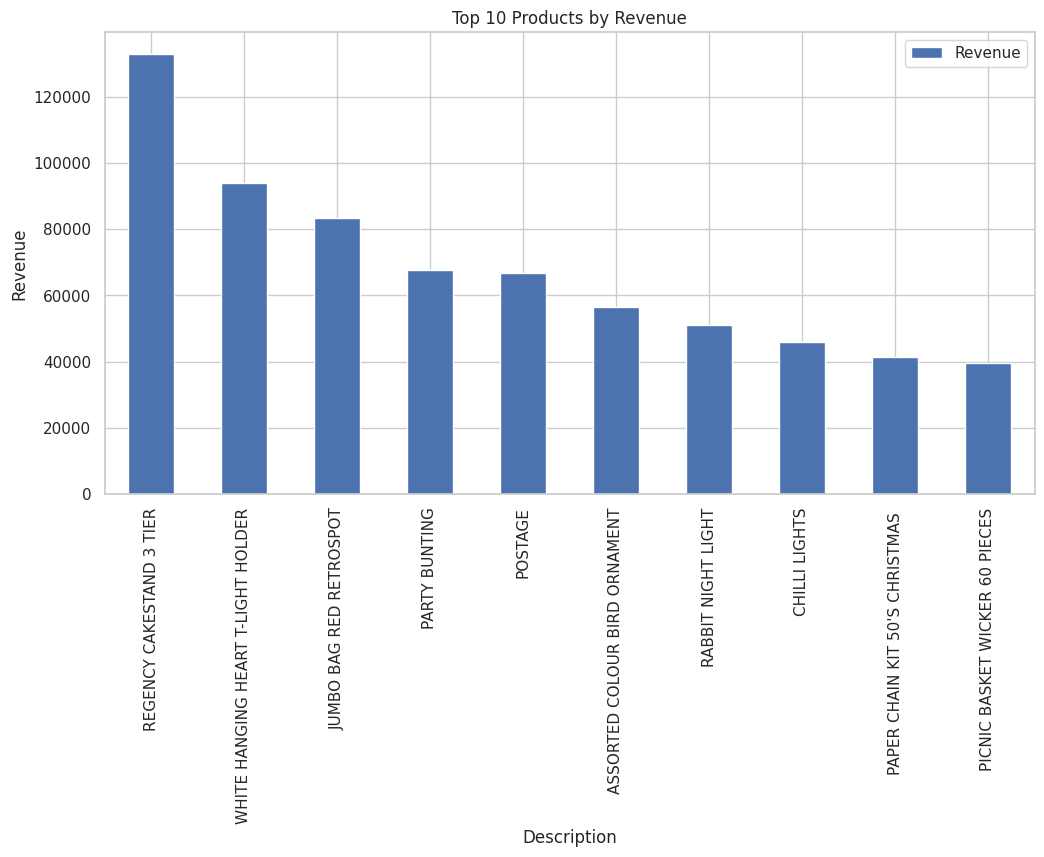

In [0]:
top_products_pdf = top_products.toPandas()
top_products_pdf.plot(kind='bar', x='Description', y='Revenue', figsize=(12,6), title='Top 10 Products by Revenue')
plt.ylabel('Revenue')
plt.show()

CustomerID,Revenue
14646.0,279489.0199999999
18102.0,256438.49
17450.0,187482.16999999998
14911.0,132572.62
12415.0,123725.44999999998
14156.0,113384.13999999997
17511.0,88125.38
16684.0,65892.07999999999
13694.0,62653.09999999999
15311.0,59419.33999999998


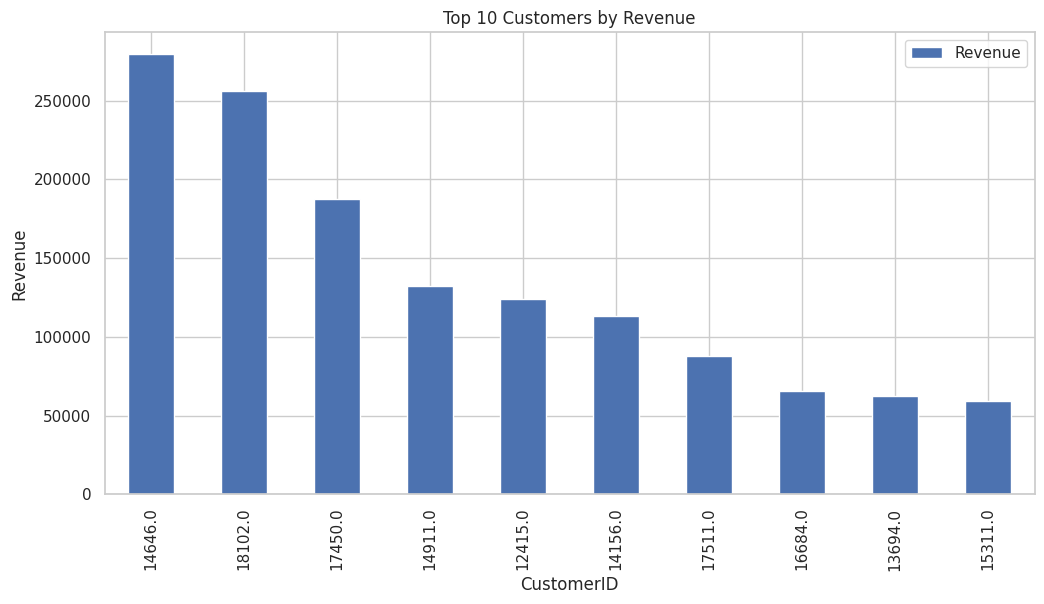

In [0]:

# 6️⃣ Top 10 Customers by Revenue

top_customers = spark.sql("""
    SELECT CustomerID, SUM(TotalPrice) AS Revenue
    FROM retail_table
    GROUP BY CustomerID
    ORDER BY Revenue DESC
    LIMIT 10
""")
display(top_customers)

top_customers_pdf = top_customers.toPandas()
top_customers_pdf.plot(kind='bar', x='CustomerID', y='Revenue', figsize=(12,6), title='Top 10 Customers by Revenue')
plt.ylabel('Revenue')
plt.show()


Year,Month,Revenue
2010,12,554604.020000018
2011,1,475074.38000001636
2011,2,436546.15000001196
2011,3,579964.6100000151
2011,4,426047.851000006
2011,5,648251.080000003
2011,6,608013.1600000104
2011,7,574238.481000011
2011,8,616368.0000000092
2011,9,931440.3720000165


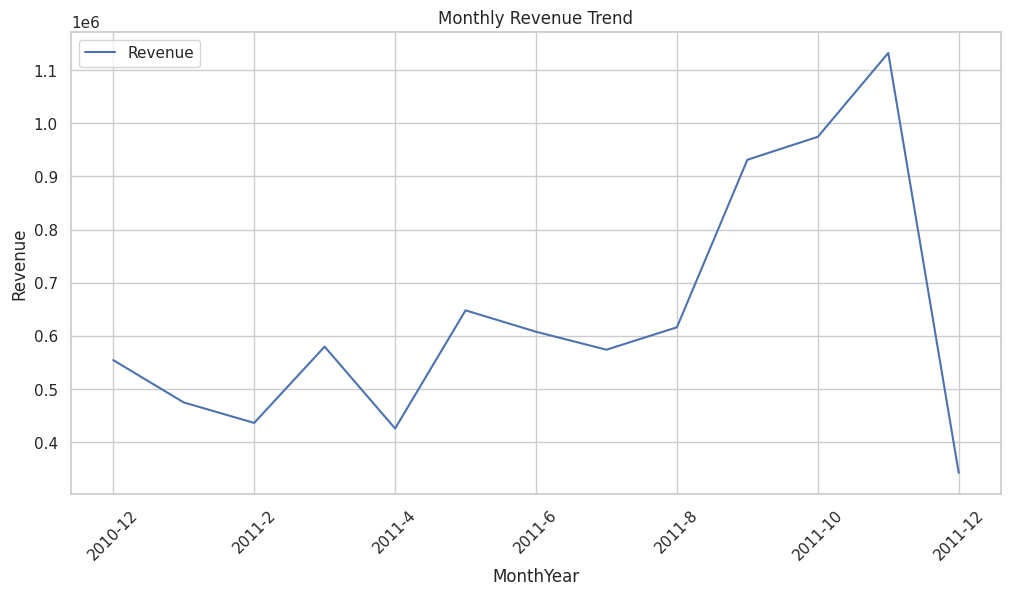

In [0]:

# Monthly Revenue Trend
monthly_sales = spark.sql("""
    SELECT YEAR(InvoiceDate) AS Year, MONTH(InvoiceDate) AS Month, SUM(TotalPrice) AS Revenue
    FROM retail_table
    GROUP BY YEAR(InvoiceDate), MONTH(InvoiceDate)
    ORDER BY Year, Month
""")
display(monthly_sales)

monthly_sales_pdf = monthly_sales.toPandas()
monthly_sales_pdf['MonthYear'] = monthly_sales_pdf['Year'].astype(str) + '-' + monthly_sales_pdf['Month'].astype(str)
monthly_sales_pdf.plot(x='MonthYear', y='Revenue', kind='line', figsize=(12,6), title='Monthly Revenue Trend')
plt.ylabel('Revenue')
plt.xticks(rotation=45)
plt.show()


Country,Revenue
United Kingdom,6767873.393999986
Netherlands,284661.5399999999
EIRE,250285.2200000001
Germany,221698.21000000002
France,196712.83999999997
Australia,137077.26999999996
Switzerland,55739.39999999999
Spain,54774.58
Belgium,40910.96
Sweden,36595.91


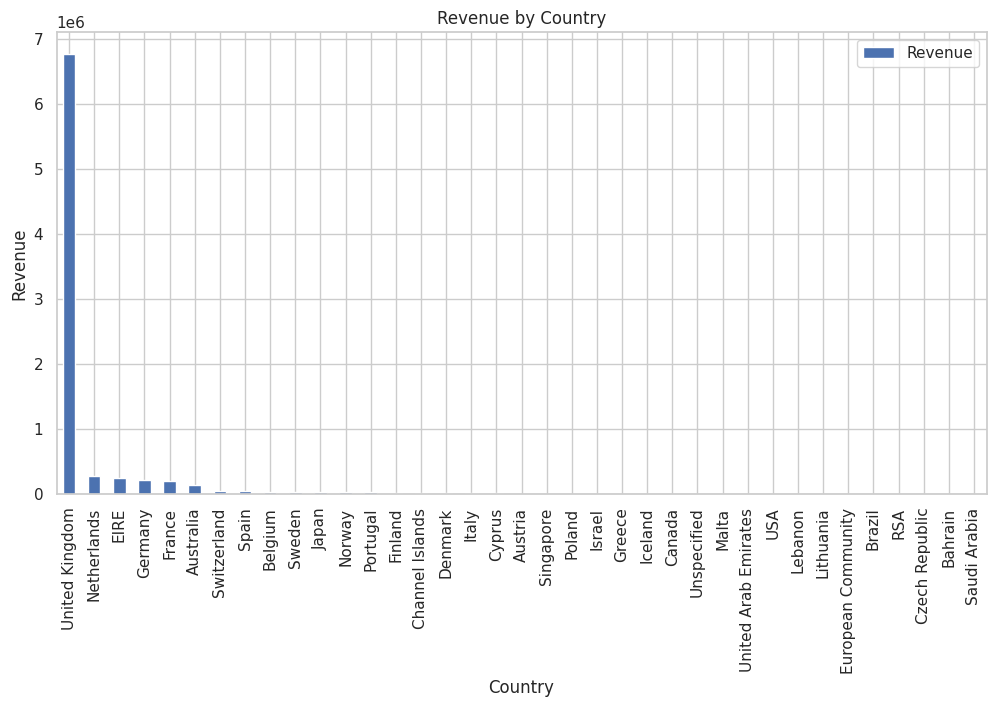

In [0]:

# 8️⃣ Revenue by Country

country_sales = spark.sql("""
    SELECT Country, SUM(TotalPrice) AS Revenue
    FROM retail_table
    GROUP BY Country
    ORDER BY Revenue DESC
""")
display(country_sales)

country_sales_pdf = country_sales.toPandas()
country_sales_pdf.plot(kind='bar', x='Country', y='Revenue', figsize=(12,6), title='Revenue by Country')
plt.ylabel('Revenue')
plt.show()


# Monthly Placed vs Cancelled Orders

In [0]:
monthly_orders = spark.sql("""
    SELECT 
        YEAR(InvoiceDate) AS Year,
        MONTH(InvoiceDate) AS Month,
        COUNT(DISTINCT CASE WHEN InvoiceNo NOT LIKE 'C%' THEN InvoiceNo END) AS PlacedOrders,
        COUNT(DISTINCT CASE WHEN InvoiceNo LIKE 'C%' THEN InvoiceNo END) AS CancelledOrders
    FROM retail_table
    GROUP BY YEAR(InvoiceDate), MONTH(InvoiceDate)
    ORDER BY Year, Month
""")
display(monthly_orders)


Year,Month,PlacedOrders,CancelledOrders
2010,12,1400,308
2011,1,987,249
2011,2,998,204
2011,3,1321,298
2011,4,1149,235
2011,5,1555,294
2011,6,1393,314
2011,7,1331,262
2011,8,1281,263
2011,9,1756,322


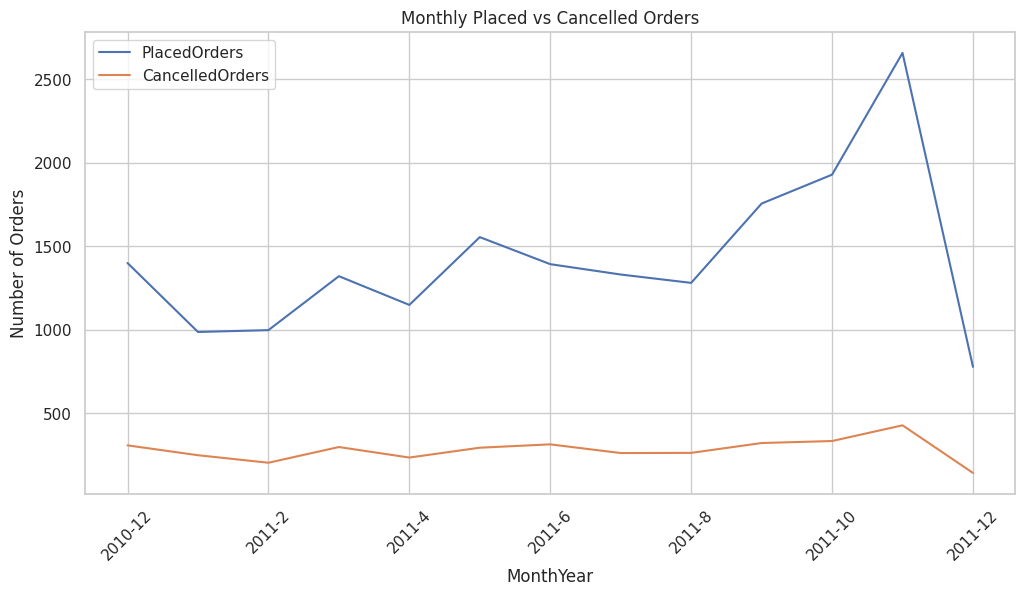

In [0]:
# Convert to Pandas for plotting
monthly_orders_pdf = monthly_orders.toPandas()
monthly_orders_pdf['MonthYear'] = monthly_orders_pdf['Year'].astype(str) + '-' + monthly_orders_pdf['Month'].astype(str)

# Plot placed vs cancelled
monthly_orders_pdf.plot(x='MonthYear', y=['PlacedOrders', 'CancelledOrders'], kind='line',
                        figsize=(12,6), title='Monthly Placed vs Cancelled Orders')
plt.ylabel('Number of Orders')
plt.xticks(rotation=45)
plt.show()


# Monthly Sales Volume (Units Sold)

In [0]:
monthly_sales_volume = spark.sql("""
    SELECT 
        YEAR(InvoiceDate) AS Year,
        MONTH(InvoiceDate) AS Month,
        SUM(Quantity) AS UnitsSold
    FROM retail_table
    WHERE InvoiceNo NOT LIKE 'C%'   -- exclude cancelled orders
    GROUP BY YEAR(InvoiceDate), MONTH(InvoiceDate)
    ORDER BY Year, Month
""")
display(monthly_sales_volume)


Year,Month,UnitsSold
2010,12,312280
2011,1,349147
2011,2,265638
2011,3,348544
2011,4,292225
2011,5,373685
2011,6,363699
2011,7,369432
2011,8,398938
2011,9,544899


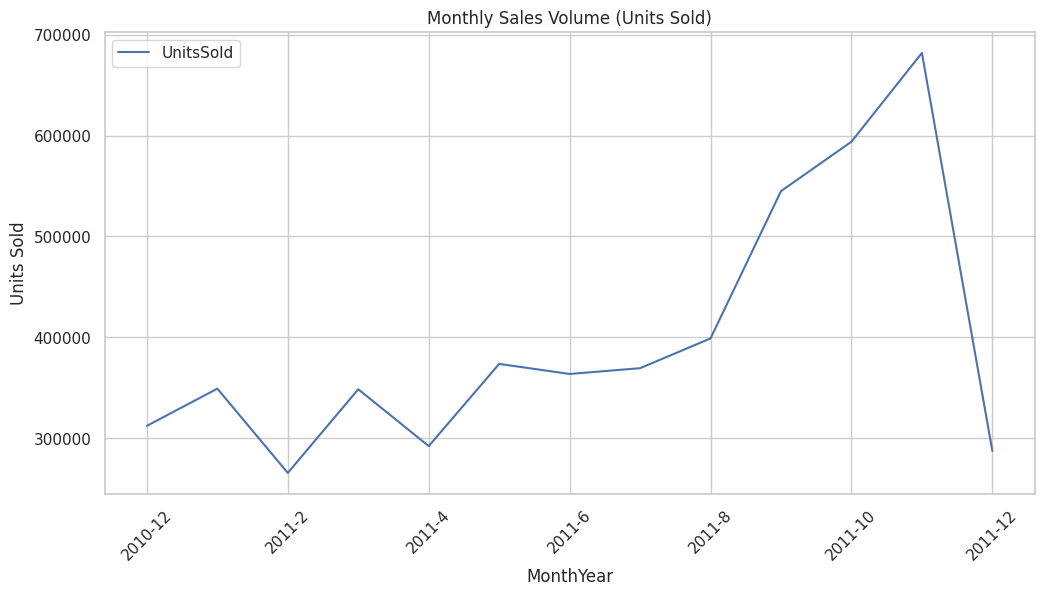

In [0]:
# Convert to Pandas for plotting
monthly_sales_volume_pdf = monthly_sales_volume.toPandas()
monthly_sales_volume_pdf['MonthYear'] = monthly_sales_volume_pdf['Year'].astype(str) + '-' + monthly_sales_volume_pdf['Month'].astype(str)

monthly_sales_volume_pdf.plot(x='MonthYear', y='UnitsSold', kind='line', figsize=(12,6),
                              title='Monthly Sales Volume (Units Sold)')
plt.ylabel('Units Sold')
plt.xticks(rotation=45)
plt.show()


# Monthly Sales Growth (Revenue)

In [0]:
monthly_sales_growth = spark.sql("""
    SELECT 
        YEAR(InvoiceDate) AS Year,
        MONTH(InvoiceDate) AS Month,
        SUM(UnitPrice * Quantity) AS Revenue
    FROM retail_table
    WHERE InvoiceNo NOT LIKE 'C%'   -- exclude cancellations
    GROUP BY YEAR(InvoiceDate), MONTH(InvoiceDate)
    ORDER BY Year, Month
""")

from pyspark.sql.window import Window
import pyspark.sql.functions as F

# Define window to look at previous month's revenue
windowSpec = Window.orderBy("Year", "Month")

monthly_sales_growth = monthly_sales_growth.withColumn(
    "PrevRevenue",
    F.lag("Revenue").over(windowSpec)
).withColumn(
    "MoM_Growth_Percent",
    F.when(F.col("PrevRevenue").isNotNull(),
           (F.col("Revenue") - F.col("PrevRevenue")) / F.col("PrevRevenue") * 100
    ).otherwise(None)
)

display(monthly_sales_growth)


/databricks/python/lib/python3.12/site-packages/pyspark/sql/connect/expressions.py:1061: UserWarning: WARN WindowExpression: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
  warnings.warn(


Year,Month,Revenue,PrevRevenue,MoM_Growth_Percent
2010,12,572713.8900000163,null,null
2011,1,569445.0400000077,572713.8900000163,-0.5707649241767994
2011,2,447137.3500000123,569445.0400000077,-21.47840114649058
2011,3,595500.760000013,447137.3500000123,33.18072399901208
2011,4,469200.36100000783,595500.760000013,-21.209107944715715
2011,5,678594.5600000018,469200.36100000783,44.62788531400778
2011,6,661213.690000011,678594.5600000018,-2.56130405760853
2011,7,600091.0110000134,661213.690000011,-9.244012930221777
2011,8,645343.900000009,600091.0110000134,7.5410043094270796
2011,9,952838.3820000166,645343.900000009,47.64815813708061


/databricks/python/lib/python3.12/site-packages/pyspark/sql/connect/expressions.py:1061: UserWarning: WARN WindowExpression: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
  warnings.warn(


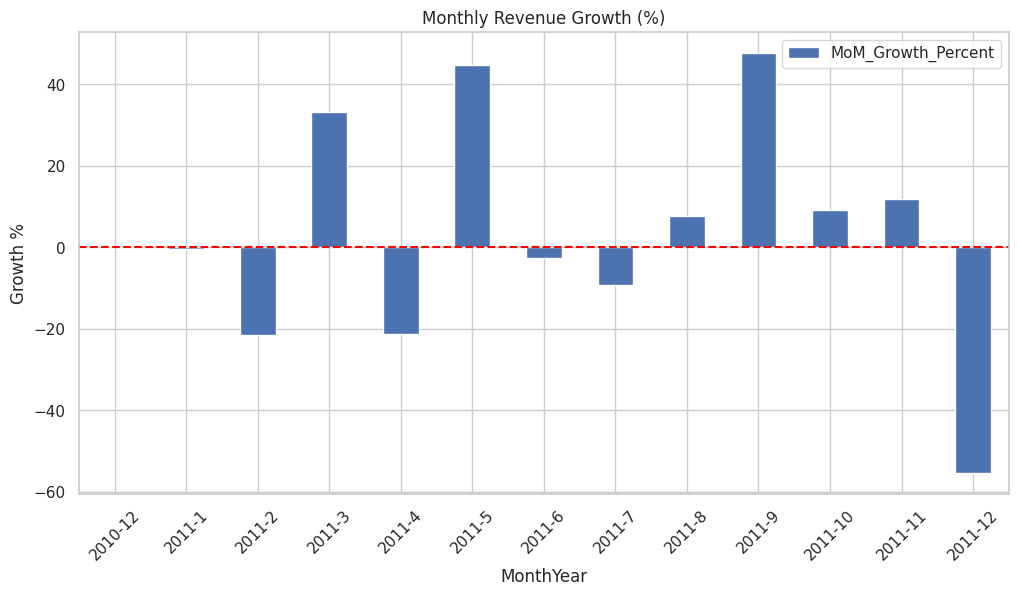

In [0]:
monthly_sales_growth_pdf = monthly_sales_growth.toPandas()
monthly_sales_growth_pdf['MonthYear'] = monthly_sales_growth_pdf['Year'].astype(str) + '-' + monthly_sales_growth_pdf['Month'].astype(str)



# Plot MoM Growth
monthly_sales_growth_pdf.plot(x='MonthYear', y='MoM_Growth_Percent', kind='bar',
                              figsize=(12,6), title='Monthly Revenue Growth (%)')
plt.ylabel('Growth %')
plt.xticks(rotation=45)
plt.axhline(0, color='red', linestyle='--')
plt.show()


# Monthly Active Users

In [0]:
monthly_active_users = spark.sql("""
    SELECT 
        YEAR(InvoiceDate) AS Year,
        MONTH(InvoiceDate) AS Month,
        COUNT(DISTINCT CustomerID) AS ActiveUsers
    FROM retail_table
    WHERE InvoiceNo NOT LIKE 'C%'   -- exclude cancelled orders
      AND CustomerID IS NOT NULL    -- ignore missing customer IDs
    GROUP BY YEAR(InvoiceDate), MONTH(InvoiceDate)
    ORDER BY Year, Month
""")

display(monthly_active_users)


Year,Month,ActiveUsers
2010,12,885
2011,1,741
2011,2,758
2011,3,974
2011,4,856
2011,5,1056
2011,6,991
2011,7,949
2011,8,935
2011,9,1266


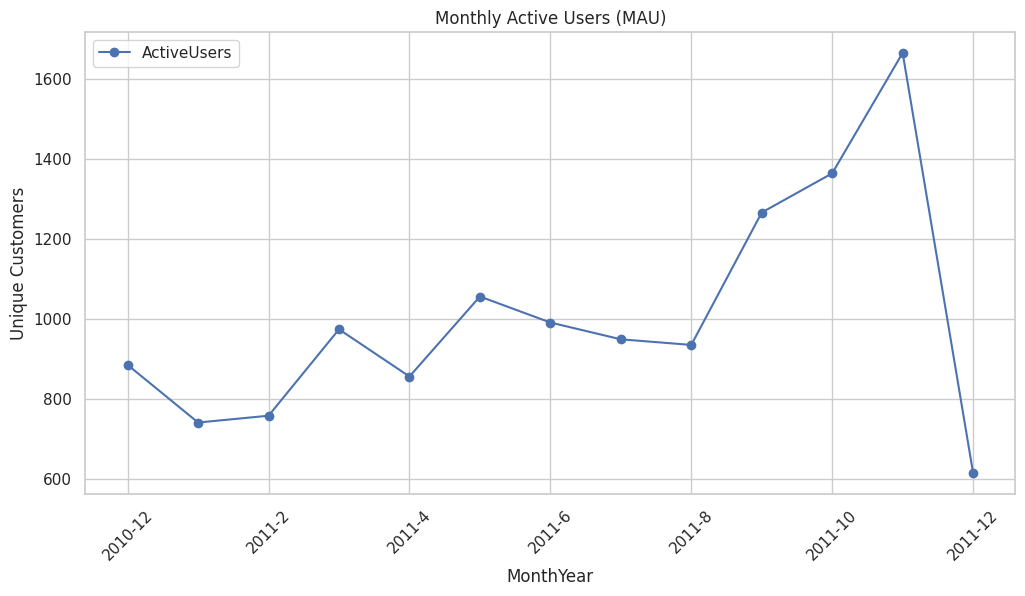

In [0]:
monthly_active_users_pdf = monthly_active_users.toPandas()
monthly_active_users_pdf['MonthYear'] = monthly_active_users_pdf['Year'].astype(str) + '-' + monthly_active_users_pdf['Month'].astype(str)

monthly_active_users_pdf.plot(
    x='MonthYear', y='ActiveUsers', kind='line', marker='o',
    figsize=(12,6), title='Monthly Active Users (MAU)'
)
plt.ylabel('Unique Customers')
plt.xticks(rotation=45)
plt.show()


In [0]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window

# Step 1: Get each customer's first purchase date
first_purchase = retail_df.filter(~F.col("InvoiceNo").like("C%")) \
    .filter(F.col("CustomerID").isNotNull()) \
    .groupBy("CustomerID") \
    .agg(F.min("InvoiceDate").alias("FirstPurchaseDate"))

# Step 2: Add Year, Month for first purchase
first_purchase = first_purchase.withColumn("FirstYear", F.year("FirstPurchaseDate")) \
                               .withColumn("FirstMonth", F.month("FirstPurchaseDate"))

# Step 3: Add Year, Month to transactions
transactions = retail_df.filter(~F.col("InvoiceNo").like("C%")) \
    .filter(F.col("CustomerID").isNotNull()) \
    .withColumn("Year", F.year("InvoiceDate")) \
    .withColumn("Month", F.month("InvoiceDate"))

# Step 4: Join to mark new vs existing
txn_with_first = transactions.join(first_purchase, "CustomerID")

user_type_df = txn_with_first.withColumn(
    "UserType",
    F.when((F.col("Year") == F.col("FirstYear")) & (F.col("Month") == F.col("FirstMonth")), "New")
     .otherwise("Existing")
)

# Step 5: Aggregate counts
new_existing_users = user_type_df.groupBy("Year", "Month", "UserType") \
    .agg(F.countDistinct("CustomerID").alias("Users")) \
    .orderBy("Year", "Month", "UserType")

display(new_existing_users)


Year,Month,UserType,Users
2010,12,New,885
2011,1,Existing,324
2011,1,New,417
2011,2,Existing,378
2011,2,New,380
2011,3,Existing,522
2011,3,New,452
2011,4,Existing,556
2011,4,New,300
2011,5,Existing,772


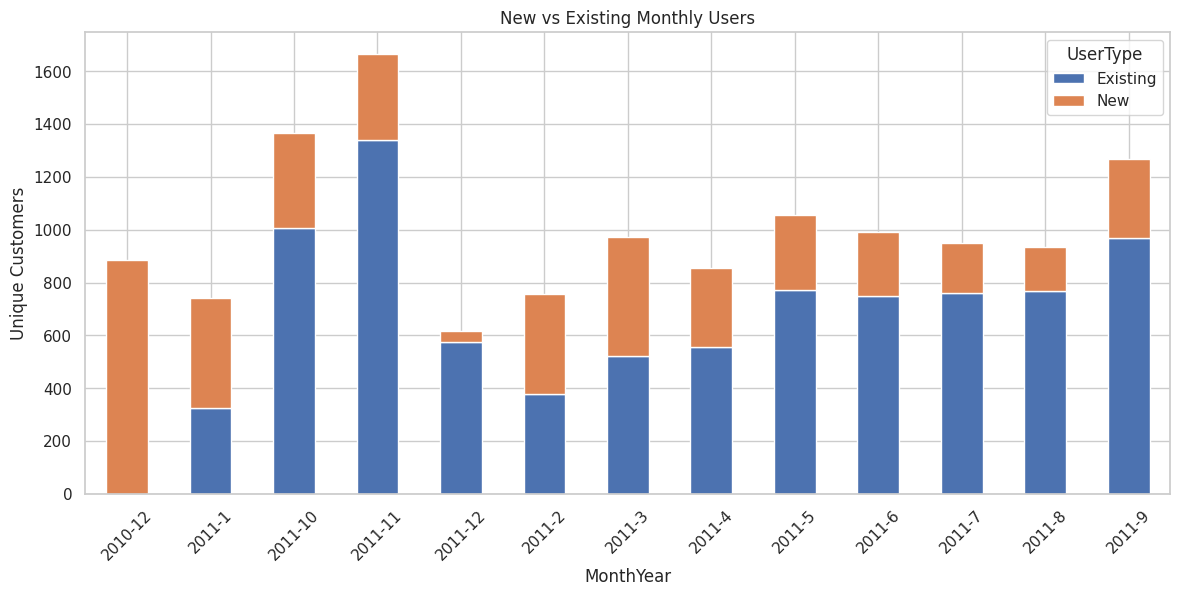

In [0]:
new_existing_pdf = new_existing_users.toPandas()
new_existing_pdf['MonthYear'] = new_existing_pdf['Year'].astype(str) + '-' + new_existing_pdf['Month'].astype(str)

pivot_df = new_existing_pdf.pivot(index="MonthYear", columns="UserType", values="Users").fillna(0)

pivot_df.plot(
    kind="bar", figsize=(14,6), stacked=True,
    title="New vs Existing Monthly Users"
)
plt.ylabel("Unique Customers")
plt.xticks(rotation=45)
plt.show()


# RFM Analysis (Recency, Frequency, Monetary)

In [0]:
from pyspark.sql import functions as F

# Use a reference date (e.g., one day after the last transaction date)
max_date = retail_df.agg(F.max("InvoiceDate")).collect()[0][0]
reference_date = max_date + pd.Timedelta(days=1)

# Compute RFM
rfm_df = retail_df.filter(~F.col("InvoiceNo").like("C%")) \
    .filter(F.col("CustomerID").isNotNull()) \
    .withColumn("Revenue", F.col("Quantity") * F.col("UnitPrice")) \
    .groupBy("CustomerID") \
    .agg(
        F.max("InvoiceDate").alias("LastPurchaseDate"),
        F.countDistinct("InvoiceNo").alias("Frequency"),
        F.sum("Revenue").alias("Monetary")
    ) \
    .withColumn("Recency", F.datediff(F.lit(reference_date), F.col("LastPurchaseDate"))) \
    .select("CustomerID", "Recency", "Frequency", "Monetary")

display(rfm_df.limit(10))


CustomerID,Recency,Frequency,Monetary
17838.0,27,5,2779.2999999999997
15512.0,156,2,121.0
12782.0,5,5,2330.92
18071.0,258,2,453.0
12408.0,33,5,2888.55
14364.0,109,8,3717.3500000000004
13617.0,41,3,544.1800000000001
13236.0,25,2,744.8499999999999
13160.0,23,1,91.8
17094.0,323,1,301.99999999999994


In [0]:
# Define quantiles for scoring
quantiles = rfm_df.approxQuantile(["Recency", "Frequency", "Monetary"], [0.2, 0.4, 0.6, 0.8], 0.01)

r_cutoffs = quantiles[0]  # for Recency
f_cutoffs = quantiles[1]  # for Frequency
m_cutoffs = quantiles[2]  # for Monetary

def r_score(recency):
    if recency <= r_cutoffs[0]: return 5
    elif recency <= r_cutoffs[1]: return 4
    elif recency <= r_cutoffs[2]: return 3
    elif recency <= r_cutoffs[3]: return 2
    else: return 1

def fm_score(value, cutoffs):
    if value <= cutoffs[0]: return 1
    elif value <= cutoffs[1]: return 2
    elif value <= cutoffs[2]: return 3
    elif value <= cutoffs[3]: return 4
    else: return 5

r_score_udf = F.udf(r_score, "int")
fm_score_udf = F.udf(lambda x: fm_score(x, f_cutoffs), "int")
mm_score_udf = F.udf(lambda x: fm_score(x, m_cutoffs), "int")

rfm_scored = rfm_df.withColumn("R_Score", r_score_udf("Recency")) \
    .withColumn("F_Score", fm_score_udf("Frequency")) \
    .withColumn("M_Score", mm_score_udf("Monetary")) \
    .withColumn("RFM_Segment", F.concat_ws("", "R_Score", "F_Score", "M_Score")) \
    .withColumn("RFM_Score", F.col("R_Score") + F.col("F_Score") + F.col("M_Score"))

display(rfm_scored.limit(10))


CustomerID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Segment,RFM_Score
17838.0,27,5,2779.2999999999997,4,4,5,445,13
15512.0,156,2,121.0,2,2,1,221,5
12782.0,5,5,2330.92,5,4,5,545,14
18071.0,258,2,453.0,1,2,2,122,5
12408.0,33,5,2888.55,3,4,5,345,12
14364.0,109,8,3717.3500000000004,2,5,5,255,12
13617.0,41,3,544.1800000000001,3,3,3,333,9
13236.0,25,2,744.8499999999999,4,2,3,423,9
13160.0,23,1,91.8,4,1,1,411,6
17094.0,323,1,301.99999999999994,1,1,2,112,4


In [0]:
rfm_segmented = rfm_scored.withColumn(
    "Segment",
    F.when(F.col("RFM_Score") >= 12, "Champions")
     .when((F.col("R_Score") >= 4) & (F.col("F_Score") >= 4), "Loyal Customers")
     .when((F.col("R_Score") <= 2) & (F.col("M_Score") <= 2), "Lost Customers")
     .when(F.col("R_Score") <= 2, "At Risk")
     .otherwise("Others")
)

display(rfm_segmented.groupBy("Segment").count())


Segment,count
Lost Customers,1017
Champions,1201
At Risk,709
Loyal Customers,53
Others,1359


# RFM Segmentation

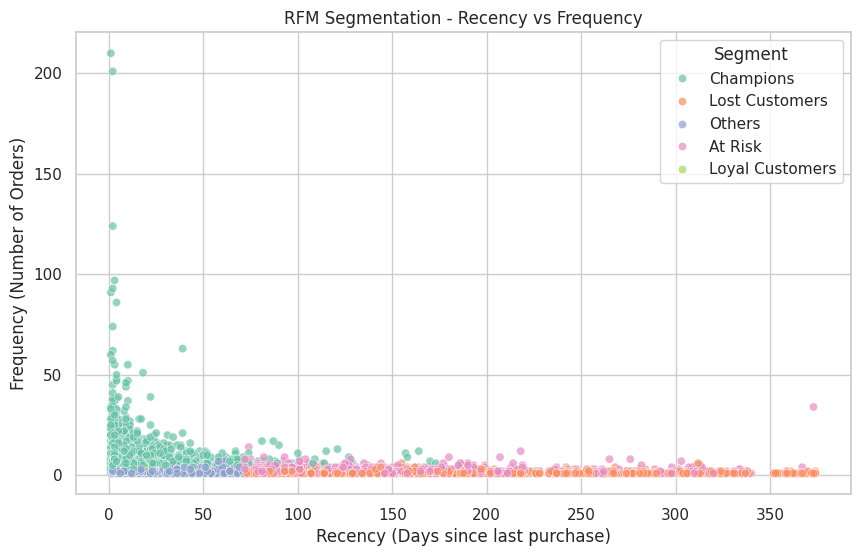

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert RFM to Pandas
rfm_pdf = rfm_segmented.select("CustomerID", "Recency", "Frequency", "Monetary", "Segment").toPandas()

# --- Scatter Plot: Recency vs Frequency ---
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=rfm_pdf,
    x="Recency",
    y="Frequency",
    hue="Segment",
    palette="Set2",
    alpha=0.7
)
plt.title("RFM Segmentation - Recency vs Frequency")
plt.xlabel("Recency (Days since last purchase)")
plt.ylabel("Frequency (Number of Orders)")
plt.legend(title="Segment")
plt.show()


## Scatter Plot: Frequency vs Monetary

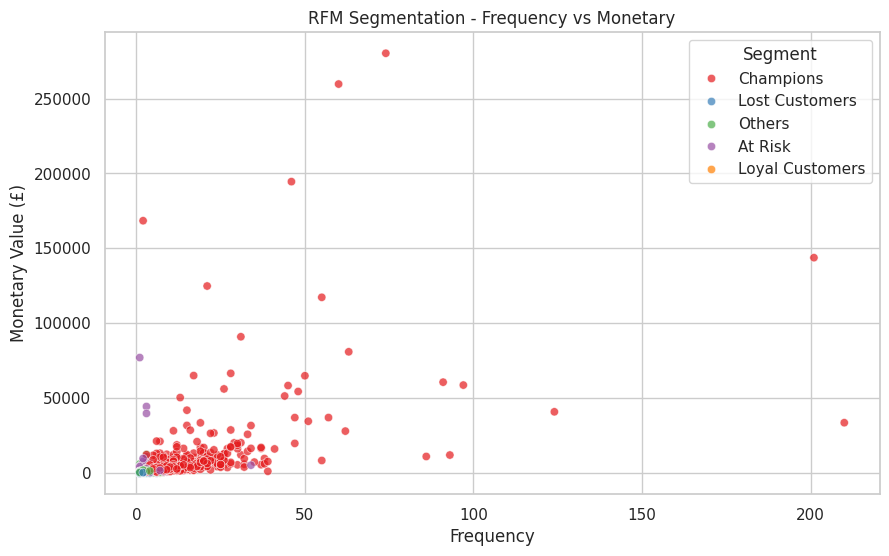

In [0]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=rfm_pdf,
    x="Frequency",
    y="Monetary",
    hue="Segment",
    palette="Set1",
    alpha=0.7
)
plt.title("RFM Segmentation - Frequency vs Monetary")
plt.xlabel("Frequency")
plt.ylabel("Monetary Value (£)")
plt.legend(title="Segment")
plt.show()


## Bar Plot: Customer Counts per Segment

/home/spark-99699224-4f3c-4d9f-bcc8-11/.ipykernel/2624/command-5434146768798593-2314207773:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


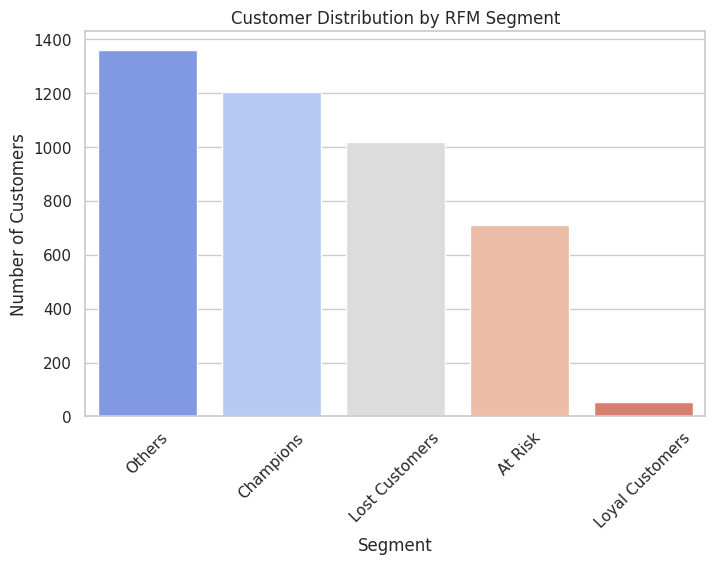

In [0]:
plt.figure(figsize=(8,5))
sns.countplot(
    data=rfm_pdf,
    x="Segment",
    order=rfm_pdf["Segment"].value_counts().index,
    palette="coolwarm"
)
plt.title("Customer Distribution by RFM Segment")
plt.xlabel("Segment")
plt.ylabel("Number of Customers")
plt.xticks(rotation=45)
plt.show()
